# Big Data in Finance

## Libraries

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import networkx as nx
import seaborn as sns
import EoN
import graphistry
from tqdm import tnrange, tqdm_notebook

In [2]:
claims = pd.read_csv('data/foreign_claims.csv', index_col=0)
scores = pd.read_csv('data/credit_score.csv', index_col=0)

## 1) Data Cleaning

<p><strong>Steps:</strong></p>
<ol>
    <li>Ensure consistent naning across countries</li>
    <li>Match country-names across two datasets</li>
    <li>Merge the credit-score dataset with the foreign-claims dataset</li>
</ol>  

In [3]:
scores.rename({'South Korea': 'Korea'}, inplace=True)         # Aligning South Korea naming with other table
scores = scores[scores.index.isin(claims.index)].sort_index() # Aligning Scores-table with df
claims = claims[claims.index.isin(scores.index)].sort_index() # Aligning df-table with scores

In [4]:
data = pd.merge(claims, scores, on='Country').drop('Rating', axis=1)
data.sort_values('Numeric Value', ascending=False)

,Foreign Claims,Derivatives,Numeric Value
Country,,,
Australia,687.6,55.5,100.0
Switzerland,1084.2,259.8,100.0
Canada,1897.9,115.3,100.0
Sweden,346.5,28.4,100.0
Singapore,567.6,24.5,100.0
Netherlands,1327.1,198.1,100.0
Germany,1873.4,695.3,100.0
Austria,391.2,20.4,95.0
United States,3599.6,225.9,95.0


## 2) Pre-Processing

<p><strong>Formulas:</strong></p>
<ul>
    <li>betas: \begin{equation}\frac{ForeignClaims}{\sum_{i=1}^n(ForeignClaims)} \end{equation}</li>
    <li>gammas: \begin{equation}\frac{1}{101-CreditScore} \end{equation}</li>
    <li>weighted betas: \begin{equation}\frac{\beta*\frac{Derivatives}{\sum_{i=1}^n(Derivatives)}}{\sum_{i=1}^n(WeightedBetas)} \end{equation}</li>
</ul>

In [5]:
data['betas'] = data['Foreign Claims'] / data['Foreign Claims'].sum()
data['gammas'] = 1 / (101 - data['Numeric Value'])
data['weighted betas'] = data['betas'] * data['Derivatives'] / data['Derivatives'].sum()
data['weighted betas'] = data['weighted betas'] / data['weighted betas'].sum()
data

,Foreign Claims,Derivatives,Numeric Value,betas,gammas,weighted betas
Country,,,,,,
Australia,687.6,55.5,100.0,0.025719,1.000000,0.006623
Austria,391.2,20.4,95.0,0.014632,0.166667,0.001385
Belgium,233.5,32.7,90.0,0.008734,0.090909,0.001325
Canada,1897.9,115.3,100.0,0.070988,1.000000,0.037976
Chile,14.2,2.6,80.0,0.000531,0.047619,0.000006
Finland,472.9,58.3,95.0,0.017688,0.166667,0.004785
France,3098.6,146.5,90.0,0.115899,0.090909,0.078780
Germany,1873.4,695.3,100.0,0.070072,1.000000,0.226055
Greece,57.7,1.0,40.0,0.002158,0.016393,0.000010


## 3) Exploratory Analysis

<p><strong>Graphs:</strong></p>
<ol>
    <li>Betas + Gammas</li>
    <li>Foreign Claims</li>
    <li>Derivatives</li>
    <li>Credit Scores</li>
</ol>  

In [6]:
def plot_graph(data, bars, xlabel=None, ylabel=None, title=None, colors=None):
    ax = data[bars].plot.bar(rot=45, figsize=(16, 9), color=colors)
    ax.set_xticklabels(list(data.index), fontsize=14, color='black', horizontalalignment='right', alpha=0.8)
    ax.set_xlabel(xlabel, fontsize=14, color='black')
    ax.set_ylabel(ylabel, fontsize=14, color='black')
    ax.set_title(title, fontsize=14)
    return ax

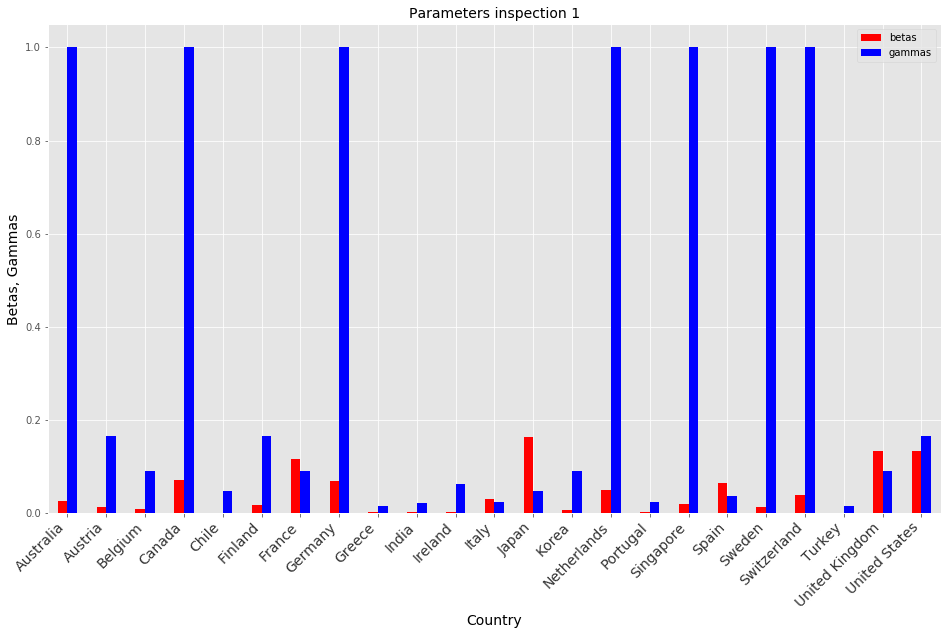

In [7]:
plot_graph(data, 
           bars=['betas', 'gammas'], 
           xlabel='Country', 
           ylabel='Betas, Gammas', 
           title='Parameters inspection 1',
           colors=['red', 'blue'])

## 4) Adding Foreign Trade as a directed weight to indicate connectedness of countries

In [8]:
for r, d, file in os.walk('data/comtrade'):
    trade = pd.read_csv(f'{r}/{file[0]}')
    for f in file[1:]:
        trade = trade.append(pd.read_csv(f'{r}/{f}'), sort=False)

In [9]:
trade = trade[['Trade Flow', 'Reporter', 'Partner', 'Trade Value (US$)']]
trade.replace({'Rep. of Korea': 'Korea', 'USA': 'United States'}, inplace=True)
trade = trade[trade['Partner'].isin(data.index)]

In [10]:
network = pd.DataFrame(columns=['Reporter', 'Partner', 'Weight'])
connections = {c: {} for c in trade['Reporter'].unique()}
for reporter in trade['Reporter'].unique():
    for partner in trade['Partner'].unique():
        flow = trade[(trade['Partner'] == partner) & (trade['Reporter'] == reporter)]
        if flow.shape == (2, 4):
            network = network.append({
                'Reporter': reporter,
                'Partner': partner,
                'Weight': flow[flow['Trade Flow'] == 'Export']['Trade Value (US$)'].iloc[0]
            }, ignore_index=True)

In [11]:
network = network[network['Weight'] >= np.percentile(network['Weight'], 30)]
network.loc[:, 'Weight'] = np.log(network['Weight'])
network.loc[:, ['Weight']] = (network['Weight'] - network['Weight'].min()) / \
                             (network['Weight'].max() - network['Weight'].min())

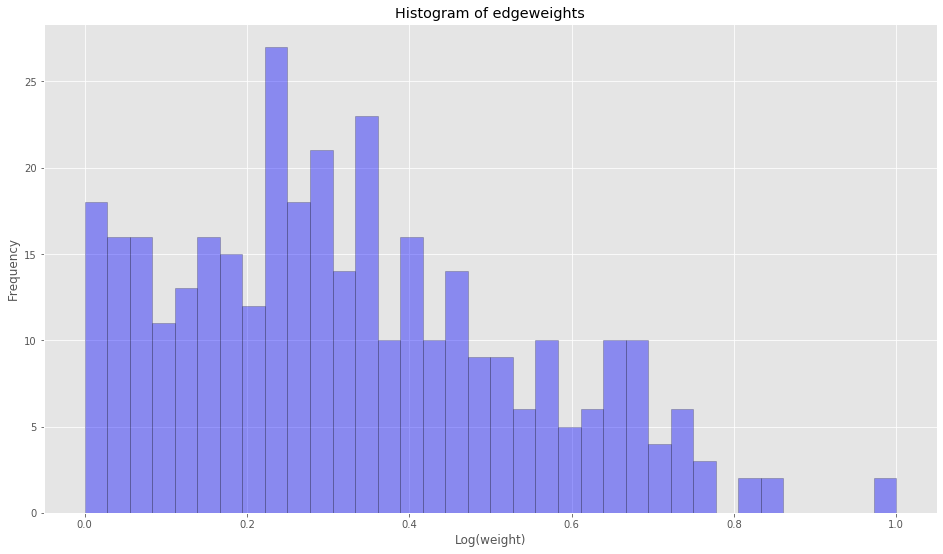

In [12]:
plt.figure(figsize=(16, 9))
sns.distplot(network['Weight'], 
             hist=True, 
             kde=False, 
             bins=int(180/5), 
             color='blue',
             hist_kws={'edgecolor': 'black'})

plt.title('Histogram of edgeweights')
plt.xlabel('Log(weight)')
plt.ylabel('Frequency')

plt.show()

In [13]:
network = network.merge(data, left_on='Reporter', right_index=True, how='left').sort_index()
network.head()

,Reporter,Partner,Weight,Foreign Claims,Derivatives,Numeric Value,betas,gammas,weighted betas
2,Australia,Canada,0.032137,687.6,55.5,100.0,0.025719,1.0,0.006623
5,Australia,France,0.005582,687.6,55.5,100.0,0.025719,1.0,0.006623
6,Australia,Germany,0.060235,687.6,55.5,100.0,0.025719,1.0,0.006623
10,Australia,Japan,0.629072,687.6,55.5,100.0,0.025719,1.0,0.006623
11,Australia,Korea,0.479358,687.6,55.5,100.0,0.025719,1.0,0.006623


In [14]:
G = nx.DiGraph()
G.add_weighted_edges_from(network[['Reporter', 'Partner', 'Weight']].to_records(index=False))

In [15]:
# Interactive graph
graphistry.register(key='8516ae2040123b8d54680c6b259df909871bda458f3f4690728093c7ce896e79')
graphistry.bind(source='Reporter', destination='Partner', edge_weight='Weight').plot(network)

<img src="network.png">

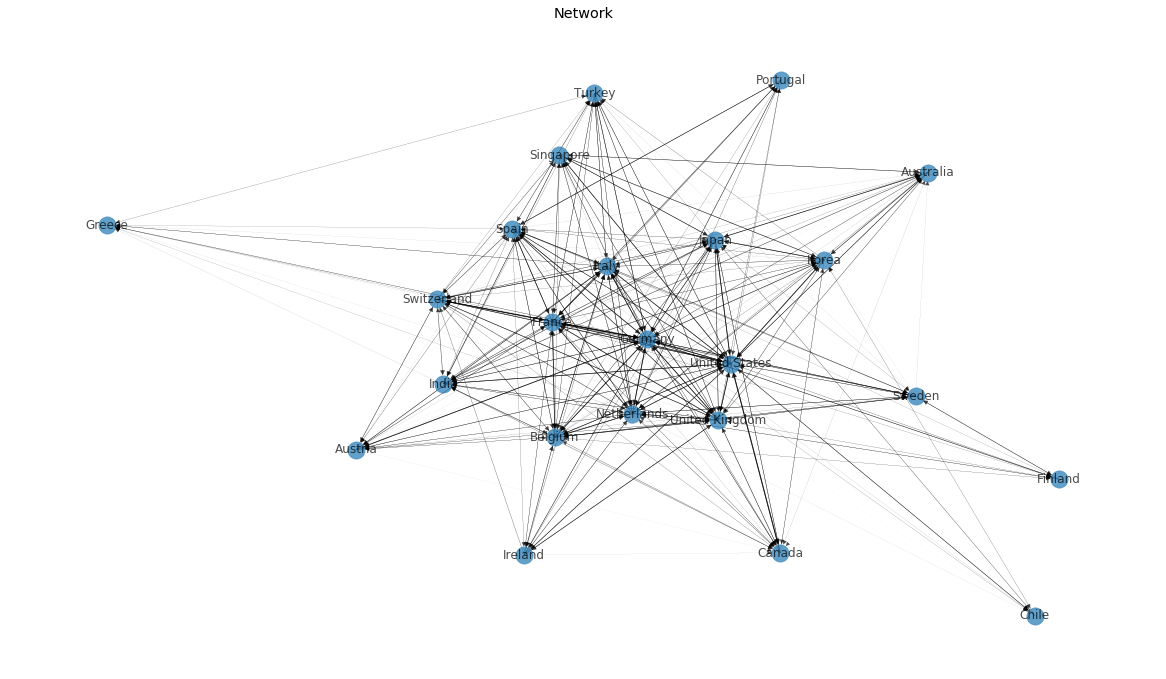

In [16]:
edgewidth = [d['weight'] for (u, v, d) in G.edges(data=True)]
nx_kwargs = {"with_labels": True, 
             "width": edgewidth, 
             "alpha": 0.7}

plt.figure(figsize=(16, 9))

fig = nx.draw(G, 
              with_labels=True, 
              alpha=0.7, 
              width=edgewidth, 
              pos=nx.fruchterman_reingold_layout(G, 
                                                 k=0.5,
                                                 iterations=20, 
                                                 weight='weight'))
plt.title("Network")
plt.show()

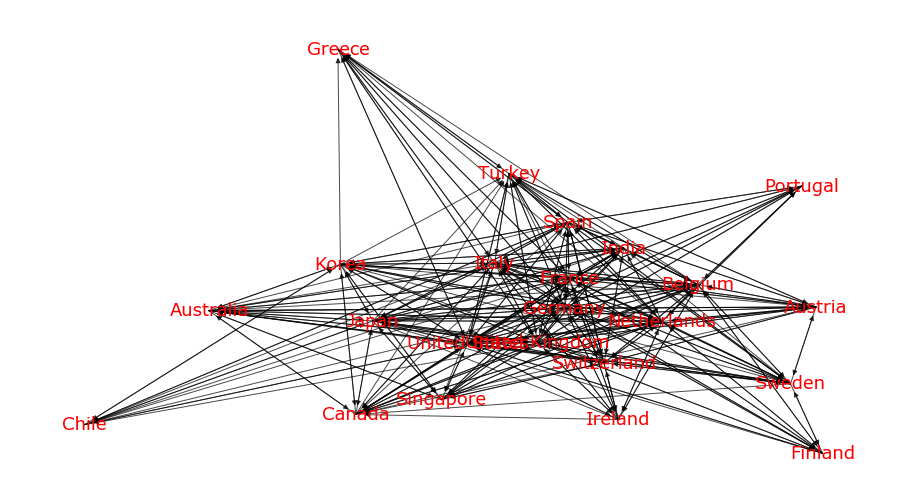

In [17]:
def plot_network(G):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(16, 9))
    plt.axis('off')
    nx.draw_networkx_edges(G, pos, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=18, font_family='verdana', font_color='red')
    plt.show()
    
plot_network(G) # We see that countries with high strength (connectedness) are in the center of the graph

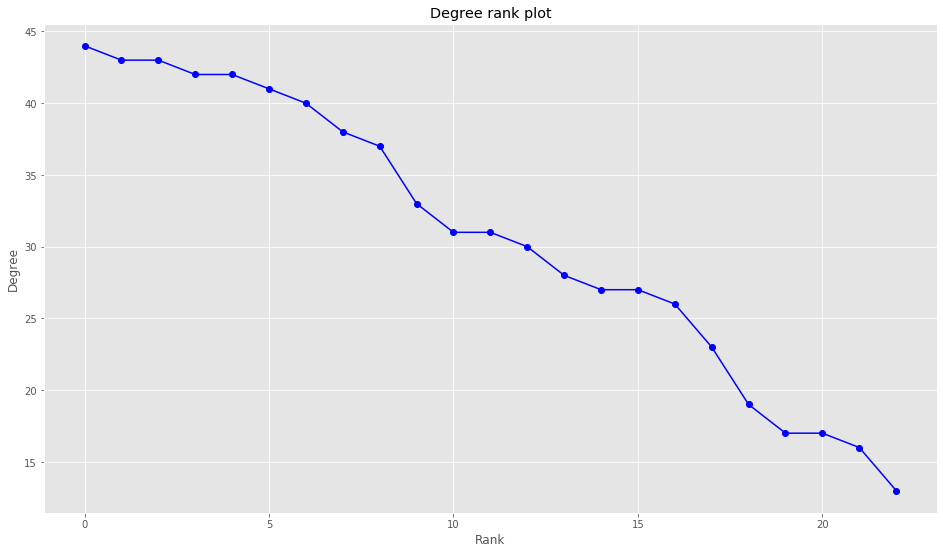

In [18]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.figure(figsize=(16, 9))
plt.plot(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("Degree")
plt.xlabel("Rank")
plt.show()

In [19]:
print(f'Diameter: {nx.diameter(G)}')
print(f'Radius: {nx.radius(G)}')
print(f'Average node connectivity: {round(nx.average_degree_connectivity(G)[44], 5)}')
print(f'Average clustering coefficient: {round(nx.average_clustering(G), 5)}')
print(f'Transitivity: {round(nx.transitivity(G), 5)}')

Diameter: 2
Radius: 1
Average node connectivity: 15.09091
Average clustering coefficient: 0.85125
Transitivity: 0.7753


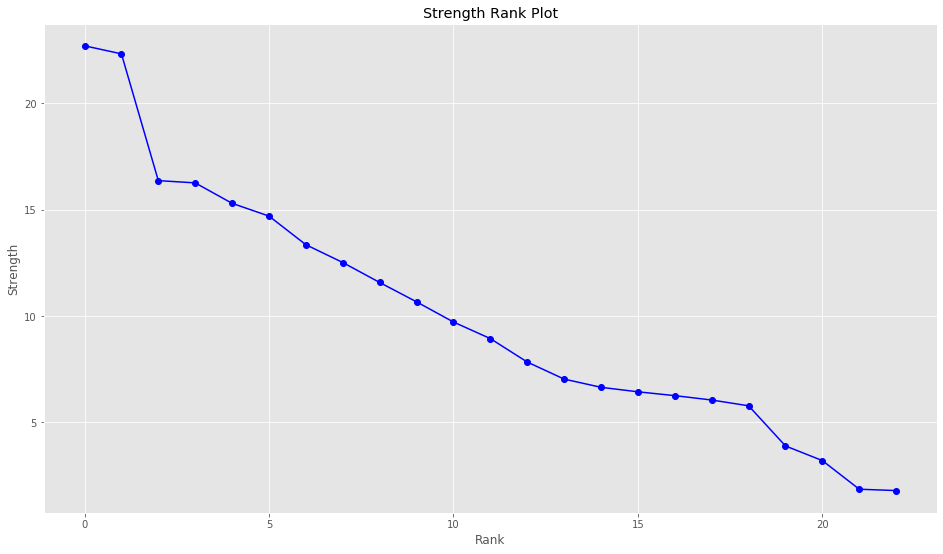

In [20]:
strength_sequence = sorted((d for n, d in G.degree(weight='weight')), reverse=True)
plt.figure(figsize=(16, 9))
plt.plot(strength_sequence,'b-', marker='o')
plt.title("Strength Rank Plot")
plt.ylabel("Strength")
plt.xlabel("Rank")
plt.show()

In [21]:
pd.DataFrame(G.degree(weight='weight'), 
             columns=['Country', 'Strength']) \
             .sort_values('Strength', ascending=False)

,Country,Strength
10,United States,22.711006
3,Germany,22.332428
9,United Kingdom,16.371096
2,France,16.264597
6,Netherlands,15.302695
16,Italy,14.703210
11,Belgium,13.356277
4,Japan,12.519907
18,Spain,11.581195
20,Switzerland,10.670634


## Instructions for the next sections of the Notebook ##

The variables that must be chosen are the following:
 - Which countries to infect first (infected nodes)
 - What magnitude of the multiplier is to be simulated
 - Nodes for credit/recovery multiplier
 - The risk multiplier (are set at the simulations)


In [22]:
risk_nodes = ['Canada', 'United States', 'Ireland', 'Greece', 'Netherlands', 'Germany']
credit_nodes = ['Italy', 'Portugal', 'India', 'Greece', 'Turkey']

# Define infected nodes:
infected_top3_dict = {c: 0.0 for c in G.nodes}
for c in ['United States', 'Germany', 'United Kingdom']:
    infected_top3_dict[c] = 1.0
    
infected_bottom3_dict = {c: 0.0 for c in G.nodes}
for c in ['Finland', 'Greece', 'Chile']:
    infected_bottom3_dict[c] = 1.0

infected_random3_dict = {c: 0.0 for c in G.nodes}
for c in ['Austria', 'Italy', 'Turkey']:
    infected_random3_dict[c] = 1.0
    
# Create node attribute for credit/recovery multiplier:
credit_dict = {c: 1.0 for c in G.nodes}
for c in credit_nodes:
    credit_dict[c] = 1.0
nx.set_node_attributes(G, credit_dict, 'credit')

# SIS Parameters

We define the basic parameters for the SIS model. In particular:

- $\mu$: recovery rate
- $\beta$: infectivity rate
- limit: the minimum number of changes to assume that the system is still in a transition state 

### RUN ONLY ONE OF BETAS OR GAMMAS based on what you want to manipulate


### Heterogeneus Betas ###
In this function we assign heterogenity to the betas based on reserves % of GDP

In [23]:
def SIS_step_beta(G, mu, beta):
    for n in G.nodes():
        q = 1
        for e in G.out_edges(n):
            q = q * (1 - (beta*G.nodes[e[1]]["risk"]) * G[e[0]][e[1]]["weight"] * G.nodes[e[1]]["infected"])
        p = G.nodes[n]["infected"]
        new_p = (1-q)*(1-p) + (1-mu)*p + mu*(1-q)*p
        if new_p >= np.random.uniform():
            G.nodes[n]["infected"] = 1
        else:
            G.nodes[n]["infected"] = 0

### Heterogeneus Gammas ###
In this function we assign heterogenity to the gammas based on credit score


In [24]:
def SIS_step_gamma(G, mu, beta):
    for n in G.nodes():
        q = 1
        for e in G.out_edges(n):
            q = q * (1 - beta * G[e[0]][e[1]]["weight"] * G.nodes[e[1]]["infected"])
        p = G.nodes[n]["infected"]
        new_p = (1-q)*(1-p) + (1-(mu*G.nodes[e[1]]["credit"]))*p + (mu*G.nodes[e[1]]["credit"])*(1-q)*p
        if new_p >= np.random.uniform():
            G.nodes[n]["infected"] = 1
        else:
            G.nodes[n]["infected"] = 0

# SIS update step function

The equation that governs the evolution of the infection process is the following:

\begin{equation}
p_{i}(t + 1) = \left(1-q_{i}(t) \right) \, \left(1 - p_{i}(t)\right) + (1 - \mu) \, p_{i}(t) + \mu \, \left(1 - q_{i}(t) \right) \, p_{i}(t) ,
\end{equation}

where $p_{i}(t)$ is the probability that a given node $i$ is infected by one of its neighbors and $q_i = \prod_{j=1}^{N}  \left(1 - \beta \,  r_{ji} \, p_j(t) \right)$ the probability that it is not infected at all.
The right hand side of the equation is explained as follows:  $\left(1 - q_{i}(t) \right) \, \left(1 - p_{i}(t) \right)$ is the probability that a given node $i$ is susceptible of  being by at least one of its neighbors. The term  $\left(1 - \mu \right)p_{i}(t)$ is the probability that an infected node $i$ does not recover. Finally, the term $\mu \left(1 - q_{i}(t) \right)p_{i}(t)$ corresponds to the probability that a given node $i$ recovers from infection but is reinfected by at least one of its neighbors.

In [25]:
def run_simulation(G, SIS_step, rmse, mu_array, beta_array, infected_dict, max_iters, limit, repetitions):
    SIS_results = np.zeros((mu_array.shape[0], beta_array.shape[0], repetitions))
    for r in tnrange(repetitions, desc=f'Repetitions: '):
        for mudx, mu in enumerate(mu_array):
            for betadx, beta in enumerate(beta_array):
                nx.set_node_attributes(G, infected_dict, "infected")
                for i in range(max_iters):
                    initial_infected = np.fromiter(nx.get_node_attributes(G, "infected").values(), dtype=int)
                    SIS_step(G, mu, beta)    
                    if (rmse(initial_infected, np.fromiter(nx.get_node_attributes(G, "infected").values(), dtype = int))<limit):
                        SIS_results[mudx,betadx,r]=np.sum(np.fromiter(nx.get_node_attributes(G, "infected").values(),dtype=int))
                        break
    return SIS_results

## Infection Graph

In [26]:
# Beta and Mu arrays
beta_array = np.around(np.arange(0, 1.01, 0.01), decimals=2)
beta_fixed_array = np.around(np.arange(0.5))
mu_array = np.around(np.arange(0, 1, 0.2), decimals=2)
mu_fixed_array = np.around(np.arange(0.5))

# RMSE function
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [27]:
def run_settings(G, risk, SIS_step, max_iters, limit, repetitions):
    risk_dict = {c: 1.0 for c in G.nodes}
    for c in risk_nodes:
        risk_dict[c] = risk
    nx.set_node_attributes(G, risk_dict, 'risk')
    results = []
    results.append(run_simulation(G, SIS_step_beta, rmse, mu_array, beta_array, infected_top3_dict, max_iters, limit, repetitions))
    results.append(run_simulation(G, SIS_step_beta, rmse, mu_array, beta_array, infected_bottom3_dict, max_iters, limit, repetitions))
    results.append(run_simulation(G, SIS_step_beta, rmse, mu_array, beta_array, infected_random3_dict, max_iters, limit, repetitions))
    return results

In [28]:
def plot_results(results, names=['Top 3', 'Bottom 3', 'Random 3']):
    color_plot = ['black', 'red', 'green', 'blue', 'yellow']
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 16))
    for i, result in enumerate(results):
        for mudx, mu in enumerate(mu_array):
            axes[i].plot(np.mean(result[mudx,:,:], axis=1)/G.number_of_nodes(), label=mu, color=color_plot[mudx])
        axes[i].set_xlabel(r'$\beta$')
        axes[i].set_title(names[i])
        axes[i].set_ylabel(r'$\rho$')
        axes[i].set_ylim(0, 1.1)
    axes[2].legend(loc='center', 
                   bbox_to_anchor=(0.5, -0.25),
                   fancybox=True, 
                   shadow=True, 
                   ncol=5)
    plt.show()

# Low Risk (1.0)

In [29]:
results = run_settings(G, 
                       risk=1.0, 
                       SIS_step=SIS_step_beta, 
                       max_iters=50,
                       limit=0.1,
                       repetitions=50)

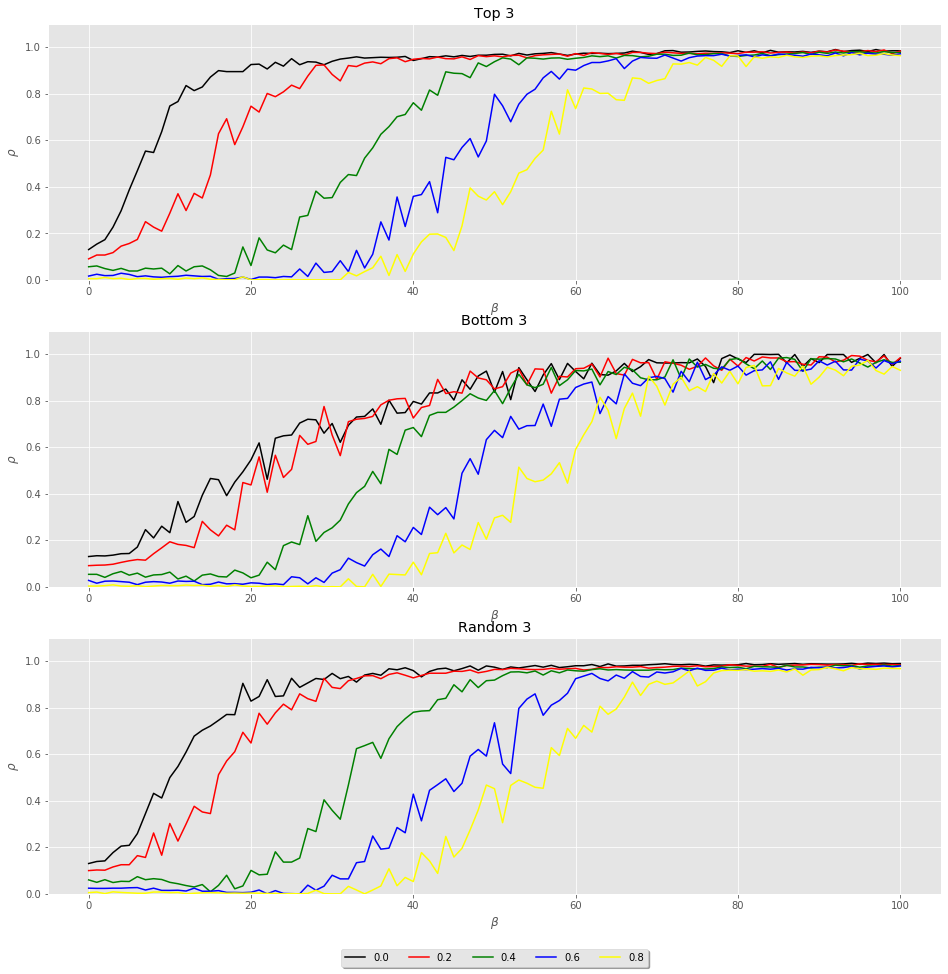

In [30]:
plot_results(results)

# Medium Risk (1.5)

In [31]:
results = run_settings(G, 
                       risk=1.5, 
                       SIS_step=SIS_step_beta, 
                       max_iters=50,
                       limit=0.1,
                       repetitions=50)

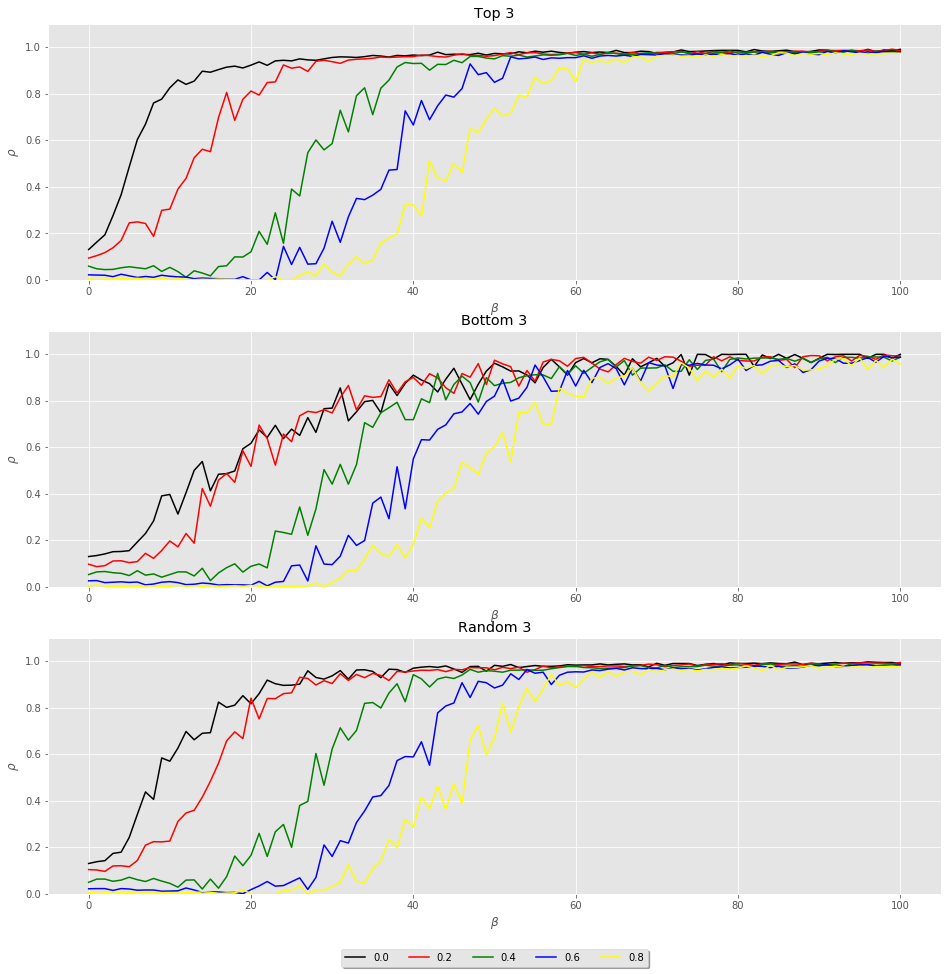

In [32]:
plot_results(results)

# High Risk (2.0)

In [33]:
results = run_settings(G, 
                       risk=2.0, 
                       SIS_step=SIS_step_beta, 
                       max_iters=50,
                       limit=0.1,
                       repetitions=50)

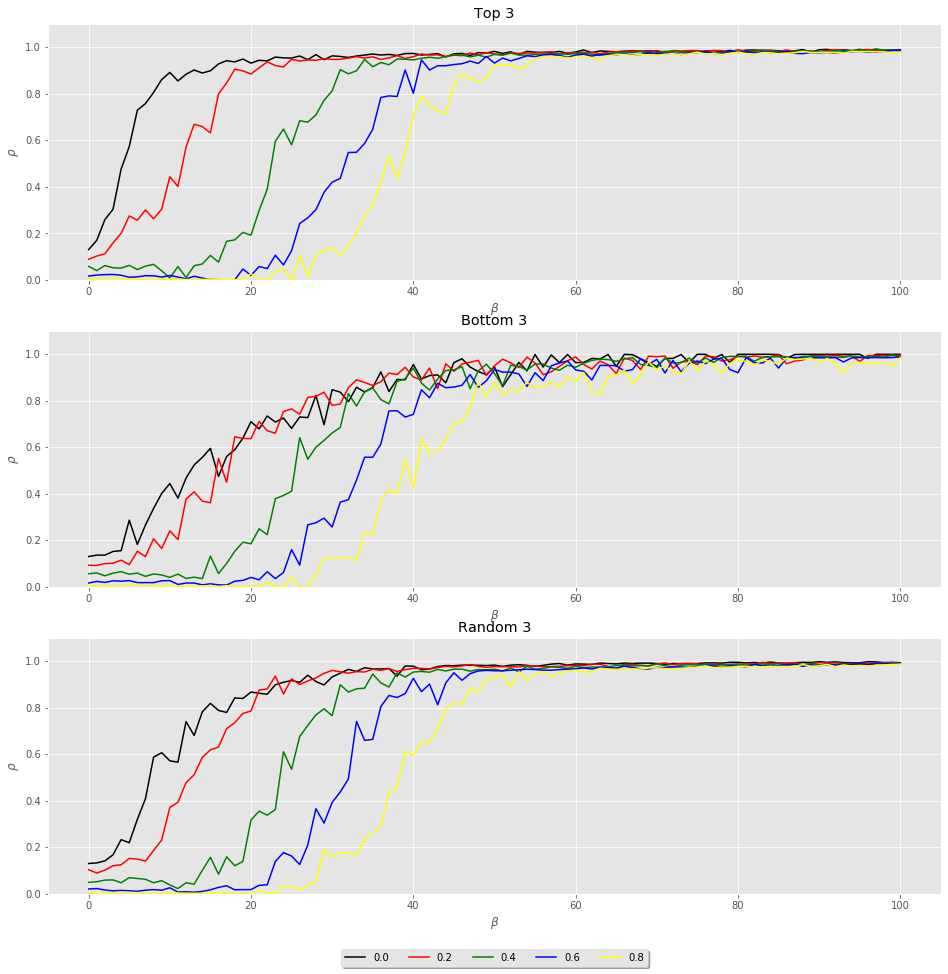

In [34]:
plot_results(results)

# Appendix

### Fixed Beta Graph:

In [35]:
# Function to plot Graph with fixed betas and gammas
def plot_results(results, names=['Normal', 'Fixed Beta', 'Fixed Gamma']):
    color_plot = ['black', 'red', 'green', 'blue', 'yellow']
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 16))
    for i, result in enumerate(results):
        if names[i] == "Fixed Beta":
            for betadx, beta in enumerate(beta_fixed_array):
                axes[i].plot(np.mean(result[:,betadx,:], axis=1)/G.number_of_nodes(), label=beta, color=color_plot[betadx])
            axes[i].set_xlabel(r'$\mu$')
        elif names[i] == "Fixed Gamma":
            for mudx, mu in enumerate(mu_fixed_array):
                axes[i].plot(np.mean(result[mudx,:,:], axis=1)/G.number_of_nodes(), label=mu, color=color_plot[mudx])
            axes[i].set_xlabel(r'$\beta$')
        else:
            for mudx, mu in enumerate(mu_array):
                axes[i].plot(np.mean(result[mudx,:,:], axis=1)/G.number_of_nodes(), label=mu, color=color_plot[mudx])
            axes[i].set_xlabel(r'$\beta$')
        axes[i].set_title(names[i])
        axes[i].set_ylabel(r'$\rho$')
        axes[i].set_ylim(0, 1.1)
        axes[i].legend(loc='center', 
                       bbox_to_anchor=(0.5, -0.25),
                       fancybox=True, 
                       shadow=True, 
                       ncol=5)
    plt.show()

### Initial Attempt to an Undirected Network SIR Model

In [36]:
# Grece
betas_nx=np.zeros(23**2).reshape(23, 23)
for i in range(len(data)):
    for j in range(i+1, len(data)):
        if i!=j:
            betas_nx[i][j]=((data['betas'][i]+data['betas'][j])/2)

G = nx.Graph()
for i in range(len(data.index)):
    G.add_node(data.index[i], gammas_nx=data['gammas'][i])
    

for i in range(len(data.index)):
    for j in range(i+1, len(data.index)):
        G.add_edge(data.index[i], data.index[j], betas_nx=betas_nx[i][j])

In [37]:
# We assign gammas and betas as node attributes
gammas_dict = dict(zip(network['Reporter'], data['gammas']))
nx.set_node_attributes(G, gammas_dict, 'gammas_nx')

betas_dict = dict(zip(network['Reporter'], data['betas']))
nx.set_node_attributes(G, betas_dict, 'betas_nx')

In [38]:
# Grece
N = 23 # population size
I0 = 1   # initial n° of infected countries 
R0 = 0
S0 = N - I0 - R0

pos = nx.spring_layout(G)

nx_kwargs = {
    "with_labels": True, 
    "pos": pos, 
    "width": edgewidth, 
    "alpha": 0.7
}

sim = EoN.fast_SIR(G, 
                   tau=1, 
                   gamma=1, 
                   initial_infecteds='Greece', 
                   recovery_weight="gammas_nx", 
                   transmission_weight="weight", 
                   return_full_data=True)

for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

<img src='greece.png' />

In [39]:
import EoN
import matplotlib.pyplot as plt

nx_kwargs = {
    "with_labels": True
}

sim = EoN.Gillespie_SIR(G, 1, 1, return_full_data=True)
sim.display(time=1, **nx_kwargs)
plt.show()

<img src='eon.png' />